In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
import glob
import torch
import time
import matplotlib
import pandas as pd
plt.rc('font', family='serif',size=12)
matplotlib.rc('text')
matplotlib.rc('legend', fontsize=10)
matplotlib.rcParams['text.latex.preamble'] = r'\math'

In [2]:
secs4 = np.load("secs_val_19.npy")
y_pred4 = np.load("y_pred_val_19.npy")[np.where(secs4 !=35)[0]]
y_true4 = np.load("y_true_val_19.npy")[np.where(secs4 !=35)[0]]
tics4 = np.load("tic_val_19.npy")[np.where(secs4 !=35)[0]]
secs4 = secs4[np.where(secs4 !=35)[0]]


secs4_test = np.load("y_sec_test_19.npy")
y_pred4_test = np.load("y_pred_test_19.npy")[np.where(secs4_test!=18)[0]]
y_true4_test = np.load("y_true_test_19.npy")[np.where(secs4_test!=18)[0]]
tics4_test = np.load("y_tic_test_19.npy")[np.where(secs4_test!=18)[0]]
secs4_test = secs4_test[np.where(secs4_test!=18)[0]]

y_pred5_test = np.load("y_pred_test_s49_19.npy")
y_true5_test = np.load("y_true_test_s49_19.npy")
tics5_test = np.load("y_tic_test_s49_19.npy")
secs5_test = np.load("y_sec_test_s49_19.npy")

y_pred6_test = np.concatenate((np.load("y_pred_test_s50_s53_s54_19.npy"),y_pred5_test,y_pred4_test))
y_true6_test = np.concatenate((np.load("y_true_test_s50_s53_s54_19.npy"),y_true5_test,y_true4_test))
tics6_test = np.concatenate((np.load("y_tic_test_s50_s53_s54_19.npy"),tics5_test,tics4_test))
secs6_test = np.concatenate((np.load("y_sec_test_s50_s53_s54_19.npy"),secs5_test,secs4_test))

np.unique(secs4)

array([36, 37, 38, 42])

In [2]:
y_pred_val = np.load("y_pred_val_final_19.npy")
y_true_val = np.load("y_true_val_final_19.npy")
tics_val = np.load("tic_val_final_19.npy")
secs_val = np.load("secs_val_final_19.npy")

In [3]:
def find_cutoff(ypred,ytrue,sectors,tics,ind,sec, text = "yes"):
    
    ypred = ypred[np.where(sectors==sec)[0]]
    ytrue = ytrue[np.where(sectors==sec)[0]]
    tics = tics[np.where(sectors==sec)[0]]
    
    nonan_mask = np.where(~np.isnan(ypred))[0]
    
    ypred = ypred[nonan_mask]
    ytrue = ytrue[nonan_mask]
    tics = tics[nonan_mask]
    
    noth_mask = np.where(ytrue[:,-1]!=1)[0]
    labels_new_val = ytrue[noth_mask,:-1].copy()
    ypred = ypred[noth_mask]
    tics = tics[noth_mask]
    sectors = sectors[noth_mask]

    
    start_time = time.time()
#     labels_new_val = ytrue[:,:-1].copy()
#     labels_new_val[:,-1] += ytrue[:,-1].copy()

    a, b, c = roc_curve(labels_new_val[:,ind], ypred[:,ind])
    
#     tics_unique = np.unique(ticids)
#     #mask = np.where(sectors == sec)[0]
#     mask = ticids in tics_unique
#     ypred = y_pred[mask]
#     ytrue = y_true[mask]
#     tics = ticids[mask]
#     labels_new_val = labels_new[mask]


    tpr = []
    fpr = []
    cs = []
    pc_missed = []
    others_found = []
    
    best_other_found = 0
    
    
    if ind != 0: 
        print(ind)
        for thr in c:
            cs.append(thr)
            pc_found_mask = np.where((ypred[:,ind]<thr)&(labels_new_val[:,0] == 1))
            pc_found_tics = np.unique(tics[pc_found_mask])
            num_pc_found = len(pc_found_tics)

            pc_missed_mask = np.where((ypred[:,ind]>=thr)&(labels_new_val[:,0] == 1))
            pc_missed_tics = np.unique(tics[pc_missed_mask])
            pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
            num_pc_missed =  len(pc_missed_tics)
            
            pc_missed.append(num_pc_missed)

            other_found_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]>=thr))
            other_found_tics = np.unique(tics[other_found_mask])
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
            num_other_found =  len(other_found_tics)
            others_found.append(num_other_found)
                

            other_missed_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]<thr))
            other_missed_tics = np.unique(tics[other_missed_mask])
            other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
            num_other_missed =  len(other_missed_tics)

            tpr.append(num_other_found/(num_other_found+num_other_missed))
            fpr.append(num_pc_missed/(num_pc_missed+num_pc_found))


            #if score > max_score:
            if num_other_found > best_other_found and num_pc_missed ==0:
                #max_score = score
                best_c = thr
                best_pc = num_pc_found
                best_other_found = num_other_found
                best_missed = num_pc_missed
                best_other_missed = num_other_missed
                best_pc_tics = pc_missed_tics
                #print(num_other_found)
    else:
        
        print(ind)
        for thr in c:
            cs.append(thr)
#             tics , mask = np.unique(ticids, return_index=True)
#             ypred = y_pred[mask]
#             ytrue = y_true[mask]
#             #tics = ticids[mask]
#             labels_new_val = labels_new[mask]

            
            pc_found_mask = np.where((ypred[:,ind]>thr)&(labels_new_val[:,0] == 1))
            pc_found_tics = np.unique(tics[pc_found_mask])
            num_pc_found = len(pc_found_tics)

            pc_missed_mask = np.where((ypred[:,ind]<=thr)&(labels_new_val[:,0] == 1))
            pc_missed_tics = np.unique(tics[pc_missed_mask])
            pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
            num_pc_missed =  len(pc_missed_tics)
            
            pc_missed.append(num_pc_missed)

            other_found_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]<=thr))
            other_found_tics = np.unique(tics[other_found_mask])
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
            num_other_found =  len(other_found_tics)
            others_found.append(num_other_found)
            
#             if num_other_found < 2:
#                 continue
                

            other_missed_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]>thr))
            other_missed_tics = np.unique(tics[other_missed_mask])
            other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
            num_other_missed =  len(other_missed_tics)

            tpr.append(num_other_found/(num_other_found+num_other_missed))
            fpr.append(num_pc_missed/(num_pc_missed+num_pc_found))


            #if score > max_score:
            if num_other_found > best_other_found and num_pc_missed ==0:
                #max_score = score
                best_c = thr
                best_pc = num_pc_found
                best_other_found = num_other_found
                best_missed = num_pc_missed
                best_other_missed = num_other_missed
                best_pc_tics = pc_missed_tics
                #print(num_other_found)
        
        
    if text == "yes":
        print(f"pcs found:{best_pc}, others found: {best_other_found}, pcs missed: {best_missed}, others missed: {best_other_missed}")
        print(f"pc missed tic: {best_pc_tics}")
        print("--- %s seconds ---" % (time.time() - start_time))
        
    return best_c , tpr, fpr,cs,others_found,pc_missed,(num_pc_missed+num_pc_found),(num_other_found+num_other_missed)

In [4]:
secs = np.unique(secs_val)
all_cs = []
best_cs = []
pcs = []
ofs = []
numspc = []
numso = []
for sec in secs:
    c0, tpr0, fpr0, cs0,others_found0,pc_missed0,numpc,numo = find_cutoff(y_pred_val,y_true_val,secs_val,tics_val,0,sec,text="yes")
    best_cs.append(c0)
    all_cs.append(cs0)
    pcs.append(pc_missed0)
    ofs.append(others_found0)
    numspc.append(numpc)
    numso.append(numo)
    #c1, tpr1, fpr1, cs1,others_found1,pc_missed1 = find_cutoff(y_pred_val,y_true_val,secs_val,tics_val,1)
    #c2, tpr2, fpr2, cs2,others_found2,pc_missed2 = find_cutoff(y_pred_val,y_true_val,secs_val,tics_val,2)

0
pcs found:250, others found: 174, pcs missed: 0, others missed: 450
pc missed tic: []
--- 4.434979200363159 seconds ---
0
pcs found:222, others found: 29, pcs missed: 0, others missed: 566
pc missed tic: []
--- 4.872930526733398 seconds ---
0
pcs found:246, others found: 194, pcs missed: 0, others missed: 421
pc missed tic: []
--- 5.7016870975494385 seconds ---
0
pcs found:206, others found: 85, pcs missed: 0, others missed: 538
pc missed tic: []
--- 5.976815938949585 seconds ---
0
pcs found:186, others found: 107, pcs missed: 0, others missed: 337
pc missed tic: []
--- 4.659507989883423 seconds ---
0
pcs found:291, others found: 256, pcs missed: 0, others missed: 578
pc missed tic: []
--- 11.507962465286255 seconds ---
0
pcs found:94, others found: 27, pcs missed: 0, others missed: 355
pc missed tic: []
--- 0.6235716342926025 seconds ---


/state/partition1/job-43983896/ipykernel_2126017/2870976909.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].yaxis.set_ticklabels([None,0,None,None,None,None,1])
/state/partition1/job-43983896/ipykernel_2126017/2870976909.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].yaxis.set_ticklabels([None,0,None,None,None,None,1])


Text(33.222222222222214, 0.5, 'Fraction of Contaminants')

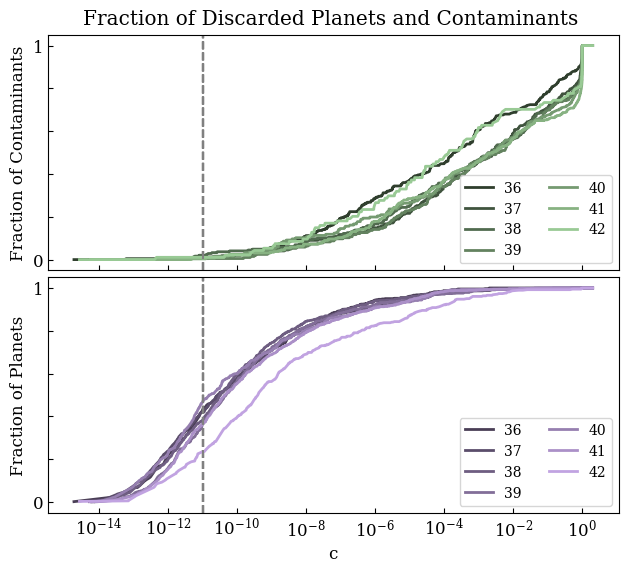

In [207]:
colors = ["#89b085","#9c89b0","#535a52","#da8c6a"]
colors = ["#786190","#62905e"]
greens = ["#88b085", "#115e41", "#a0e85b", "#21a708", "#35e0a9", "#799d10", "#3ff44c", "#f4d403"]
greens = ["#89B085", "#7D9D7A", "#779374", "#6B8069", "#657763", "#5F6D5D", "#596458", "#535A52"]
#greens = ["#88b085", "#115e41", "#a0e85b", "#21a708", "#35e0a9", "#799d10", "#3ff44c", "#f4d403"]

base_g = (0.5372549019607843,0.6901960784313725,0.5215686274509804)
base_p = (0.611764705882353,0.5372549019607843,0.6901960784313725)

cmap = np.flip(np.vstack(((0.9*np.linspace(1,0,256)+0.4)*base_g[0],(0.9*np.linspace(1,0,256)+0.4)*base_g[1],(0.9*np.linspace(1,0,256)+0.4)*base_g[2])).T**(1.1),axis=0)
cmap = matplotlib.colors.ListedColormap(cmap)
cmap2 = np.flip(np.vstack(((0.8*np.linspace(1,0,256)+0.63)*base_p[0],(0.8*np.linspace(1,0,256)+0.63)*base_p[1],(0.8*np.linspace(1,0,256)+0.63)*base_p[2])).T**(1.3),axis=0)
cmap2 = matplotlib.colors.ListedColormap(cmap2)

# cmap = np.outer(base_g,np.ones(256))
# cmap = np.vstack((cmap,np.linspace(0,1,256))).T
# print(cmap)
# cmap = matplotlib.colors.ListedColormap(cmap)
# cmap2 = np.vstack(((0.8*np.linspace(1,0,256)+0.63)*base_p[0],(0.8*np.linspace(1,0,256)+0.63)*base_p[1],(0.8*np.linspace(1,0,256)+0.63)*base_p[2])).T**(1.3)
# cmap2 = matplotlib.colors.ListedColormap(cmap2)

#plt.figure(figsize=(6,4))

fig, ax = plt.subplots(2,1,figsize=(6,5),sharex=True)
fig.suptitle("Fraction of Discarded Planets and Contaminants",y=1.04,x=0.515)
fig.tight_layout(pad=-0.6)
ax[0].yaxis.set_ticklabels([None,0,None,None,None,None,1])
ax[0].tick_params(direction="in")
ax[1].yaxis.set_ticklabels([None,0,None,None,None,None,1])
ax[1].tick_params(direction="in")
ax[0].xaxis.set_ticklabels([])
for i,val in enumerate(secs):
    ax[0].semilogx(all_cs[i],np.array(pcs[i])/numspc[i],"-",label = f"{val}",color=cmap(i/7),linewidth=2)#,alpha= i/8+0.2)#,linewidth=2,color = "#89b085")
    ax[1].semilogx(all_cs[i],np.array(ofs[i])/numso[i],"-",color=cmap2(i/7),label=f"{val}",linewidth=2)
    ax[0].axvline(10**(-11),linestyle="--",color="gray")
    ax[1].axvline(10**(-11),linestyle="--",color="gray")
ax[0].legend(loc="lower right",ncol=2)
ax[1].legend(loc="lower right",ncol=2)
plt.xlabel("c")
ax[0].set_ylim(-0.05,1.05)
ax[1].set_ylim(-0.05,1.05)
ax[1].set_ylabel("Fraction of Planets")
ax[0].set_ylabel("Fraction of Contaminants")

#plt.savefig("pcm_of_0.png",bbox_inches='tight')

(0.8866013940890016, 0.7887961491990793, 0.9882746883169892, 1.0)

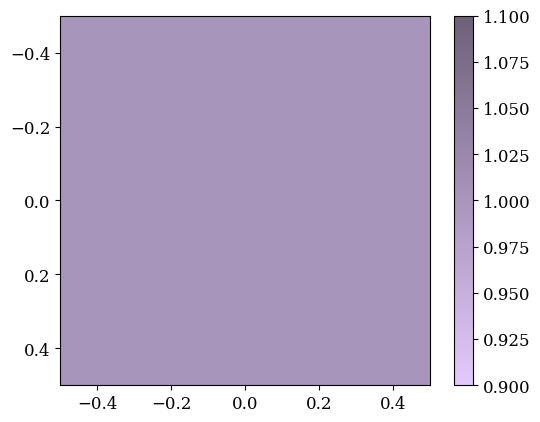

In [161]:
plt.imshow(np.ones((1,1)),cmap=cmap2)
plt.colorbar()
cmap2(0)

In [18]:
mean_c = np.average(best_cs,weights = [1/numso[0]**2,1/numso[1]**2,1/numso[2]**2,1/numso[3]**2])

In [19]:
def apply_cutoff(ypred,ytrue,tics,cutoff,ind, text = "yes"):
    
#     labels_new_val_test = ytrue[:,:-1].copy()
#     labels_new_val_test[:,-1] += ytrue[:,-1].copy()
    noth_mask = np.where(ytrue[:,-1]!=1)[0]
    labels_new_val_test = ytrue[noth_mask,:-1].copy()
    ypred = ypred[noth_mask]
    tics = tics[noth_mask]

    if ind != 0:
        
        pc_found_mask = np.where((ypred[:,0]<cutoff)&(labels_new_val_test[:,0] == 1))
        pc_found_tics = np.unique(tics[pc_found_mask])
        num_pc_found = len(pc_found_tics)
        pc_found_scores = ypred[pc_found_mask,1]

        pc_missed_mask = np.where((ypred[:,0]>=cutoff)&(labels_new_val_test[:,0] == 1))
        pc_missed_tics = np.unique(tics[pc_missed_mask])
        pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
        num_pc_missed = len(pc_missed_tics)
        pc_missed_scores = ypred[pc_missed_mask,1]

        other_found_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,0]>=cutoff))
        other_found_tics = np.unique(tics[other_found_mask])
        other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
        other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
        num_other_found = len(other_found_tics)
        other_found_scores = ypred[other_found_mask,1]

        other_missed_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,0]<cutoff))
        other_missed_tics = np.unique(tics[other_missed_mask])
        other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
        num_other_missed = len(other_missed_tics)
        other_missed_scores = ypred[other_missed_mask,1]

        eb_found_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,0]>=cutoff))
        eb_found_tics = np.unique(tics[eb_found_mask])
        eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_found_tics)]
        eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_missed_tics)]
        num_eb_found = len(eb_found_tics)

        eb_missed_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,0]<cutoff))
        eb_missed_tics = np.unique(tics[eb_missed_mask])
        eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,pc_found_tics)]
        eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,pc_missed_tics)]
        eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,eb_found_tics)]
        num_eb_missed = len(eb_missed_tics)
    

    else:
        
#         labels_new_val_test = ytrue[:,:-1].copy()
#         labels_new_val_test[:,-1] += ytrue[:,-1].copy()

        pc_found_mask = np.where((ypred[:,0]>cutoff)&(labels_new_val_test[:,0] == 1))
        pc_found_tics = np.unique(tics[pc_found_mask])
        num_pc_found = len(pc_found_tics)
        pc_found_scores = ypred[pc_found_mask,1]

        pc_missed_mask = np.where((ypred[:,0]<=cutoff)&(labels_new_val_test[:,0] == 1))
        pc_missed_tics = np.unique(tics[pc_missed_mask])
        pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
        num_pc_missed = len(pc_missed_tics)
        pc_missed_scores = ypred[pc_missed_mask,1]

        other_found_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,0]<=cutoff))
        other_found_tics = np.unique(tics[other_found_mask])
        other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
        other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
        num_other_found = len(other_found_tics)
        other_found_scores = ypred[other_found_mask,1]

        other_missed_mask = np.where((labels_new_val_test[:,0] == 0)&(ypred[:,0]>cutoff))
        other_missed_tics = np.unique(tics[other_missed_mask])
        other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
        num_other_missed = len(other_missed_tics)
        other_missed_scores = ypred[other_missed_mask,1]

        eb_found_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,0]<=cutoff))
        eb_found_tics = np.unique(tics[eb_found_mask])
        eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_found_tics)]
        eb_found_tics = eb_found_tics[~np.isin(eb_found_tics,pc_missed_tics)]
        num_eb_found = len(eb_found_tics)

        eb_missed_mask = np.where((labels_new_val_test[:,1] == 1)&(ypred[:,0]>cutoff))
        eb_missed_tics = np.unique(tics[eb_missed_mask])
        eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,pc_found_tics)]
        eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,pc_missed_tics)]
        eb_missed_tics = eb_missed_tics[~np.isin(eb_missed_tics,eb_found_tics)]
        num_eb_missed = len(eb_missed_tics)


    
    if text == "yes":
        print(f"pcs found:{num_pc_found},others found: {num_other_found}, pcs missed: {num_pc_missed}, others missed: {num_other_missed}")  
        print(f"pc missed tic: {pc_missed_tics}")
        print(f"ebs found: {num_eb_found}, ebs missed: {num_eb_missed}")
    
    return pc_found_tics, pc_missed_tics, other_found_tics, other_missed_tics, eb_found_tics, eb_missed_tics

In [163]:
pcf,pcm,of,om,ebf,ebm = apply_cutoff(y_pred5_test,y_true5_test,tics5_test,mean_c,0)

gt49 = pd.read_csv("ground_truth/ground_truth/ground_truth_49.csv")

badbad = []

for i in gt49.index:
    if gt49["TIC_ID"][i] in ebm:
        if gt49["final_score"][i] != "EB":
            badbad.append(gt49["TIC_ID"][i])
            #print(gt49["final_score"][i])
        
#len(np.where(gt49["final_score"]=="other")[0])

pcs found:229,others found: 87, pcs missed: 0, others missed: 640
pc missed tic: []
ebs found: 66, ebs missed: 302


In [22]:
for i in np.unique(secs6_test):
    print(i)
    mask = np.where(secs6_test == i)
    pcf,pcm,of,om,ebf,ebm = apply_cutoff(y_pred6_test[mask[0]],y_true6_test[mask[0]],tics6_test[mask[0]],mean_c,0)


32
pcs found:181,others found: 95, pcs missed: 0, others missed: 437
pc missed tic: []
ebs found: 68, ebs missed: 190
33
pcs found:217,others found: 108, pcs missed: 0, others missed: 263
pc missed tic: []
ebs found: 89, ebs missed: 161
48
pcs found:232,others found: 117, pcs missed: 0, others missed: 619
pc missed tic: []
ebs found: 97, ebs missed: 292
49
pcs found:229,others found: 87, pcs missed: 0, others missed: 640
pc missed tic: []
ebs found: 66, ebs missed: 302
50
pcs found:244,others found: 80, pcs missed: 0, others missed: 703
pc missed tic: []
ebs found: 62, ebs missed: 332
53
pcs found:329,others found: 158, pcs missed: 2, others missed: 651
pc missed tic: [219462190 243335710]
ebs found: 134, ebs missed: 376
54
pcs found:38,others found: 10, pcs missed: 0, others missed: 38
pc missed tic: []
ebs found: 10, ebs missed: 35


## Light Curve Plots

In [48]:
x_pcf = []
x_of = []
pos_pcf = []
pos_of = []
tic_pcf = []
tic_of = []
times_pcf = []
times_of = []

files = glob.glob("light_curves_s50/*npy")
for file in files:
    tic = int(file[17:-7])
    lc = np.load(file,allow_pickle = True)
    if tic in pcf:
        x_pcf.append(lc[1])
        pos_pcf.append(lc[8])
        tic_pcf.append(tic)
        times_pcf.append(lc[0]-lc[0][0])
    if tic in ebf:
        x_of.append(lc[1])
        pos_of.append(lc[8])
        tic_of.append(tic)
        times_of.append(lc[0]-lc[0][0])

# for i in x_of:
#     plt.figure()
#     plt.plot(i,".",markersize=1)
    
good_ones = [2,12,13,21,22,23,24,25,27]
good_ones_o = [0,2,7,9,12,14,16,18,20,21]

x_pcf = [x_pcf[i] for i in good_ones]
x_of = [x_of[i] for i in good_ones_o]
pos_pcf = [pos_pcf[i] for i in good_ones]
pos_of = [pos_of[i] for i in good_ones_o]
tic_pcf = [tic_pcf[i] for i in good_ones]
tic_of = [tic_of[i] for i in good_ones_o]
times_pcf = [times_pcf[i] for i in good_ones]
times_of = [times_of[i] for i in good_ones_o]

IndexError: list index out of range

In [ ]:


fig, axs = plt.subplots(8,1,figsize=(7,18))

for row in range(8):
    axs[row].vlines(pos_pcf[row][0],np.min(x_pcf[row]),np.max(x_pcf[row]),linestyle="dashed",linewidth = 1.5,color="#444c3c")
    axs[row].plot(times_pcf[row],x_pcf[row],".",markersize=1,color="#89b085")
    axs[row].set_xlim(pos_pcf[row][0]-1,pos_pcf[row][0]+1)
    #axs[row][col].set_title(row*cols + col)




    #axs[row][col].set_xlim(-0.2,0.2)
    #axs[row].set_ylim(-0.2,0.2)
    axs[row].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    axs[row].set_title(f"TIC {tic_pcf[row]}")
    
#fig.suptitle('Kept Planets')
#plt.savefig("keptplanets.png",bbox_inches='tight')


In [ ]:
import matplotlib
plt.rc('font', family='serif',size=12)
matplotlib.rc('text')
matplotlib.rc('legend', fontsize=10)
matplotlib.rcParams['text.latex.preamble'] = r'\math'

fig, axs = plt.subplots(8,1,figsize=(7,18))

for row in range(8):
    axs[row].vlines(pos_of[row][0],np.min(x_of[row]),np.max(x_of[row]),linestyle="dashed",linewidth = 1.5,color="#444c3c")
    axs[row].plot(times_of[row],x_of[row],".",markersize=1,color="#B284BE")
    axs[row].set_xlim(pos_of[row][0]-1,pos_of[row][0]+1)
    #axs[row][col].set_title(row*cols + col)




    #axs[row][col].set_xlim(-0.2,0.2)
    #axs[row][col].set_ylim(-0.2,0.2)
    axs[row].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    axs[row].set_title(f"TIC {tic_of[row]}")

plt.savefig("discardedcont.png",bbox_inches='tight')


In [ ]:

x_om = []
pos_om = []
tic_om = []
times_om = []

files = glob.glob("light_curves_s50/*npy")
for file in files:
    tic = int(file[17:-7])
    lc = np.load(file,allow_pickle = True)
    if tic in om:
        x_om.append(lc[1])
        pos_om.append(lc[8])
        tic_om.append(tic)
        times_om.append(lc[0]-lc[0][0])

# for i in x_om:
#     plt.figure()
#     plt.plot(i,".",markersize=1)

good_ones_o = [0,1,3,4,5,6,7,8,9,10,11,12]


x_om = [x_om[i] for i in good_ones_o]
pos_om = [pos_om[i] for i in good_ones_o]
tic_om = [tic_om[i] for i in good_ones_o]
times_om = [times_om[i] for i in good_ones_o]

In [ ]:
import matplotlib
plt.rc('font', family='serif',size=12)
matplotlib.rc('text')
matplotlib.rc('legend', fontsize=10)
matplotlib.rcParams['text.latex.preamble'] = r'\math'

fig, axs = plt.subplots(8,1,figsize=(7,18))

for row in range(8):
    axs[row].vlines(pos_om[row][0],np.min(x_om[row]),np.max(x_om[row]),linestyle="dashed",linewidth = 1.5,color="#444c3c")
    axs[row].plot(times_om[row],x_om[row],".",markersize=1,color="#89b085")
    axs[row].set_xlim(pos_om[row][0]-1,pos_om[row][0]+1)
    #axs[row][col].set_title(row*cols + col)




    #axs[row][col].set_xlim(-0.2,0.2)
    #axs[row][col].set_ylim(-0.2,0.2)
    axs[row].tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    axs[row].set_title(f"TIC {tic_om[row]}")

plt.savefig("keptothers.png",bbox_inches='tight')


In [65]:
y_pred4 = np.load("y_pred_val_19_sec_shuffle.npy")
y_true4 = np.load("y_true_val_19_sec_shuffle.npy")
tics4 = np.load("tic_val_19_sec_shuffle.npy")

In [66]:
def find_cutoff(ypred,ytrue,tics,ind, text = "yes"):

    
    start_time = time.time()
    labels_new_val = ytrue[:,:-1].copy()
    labels_new_val[:,-1] += ytrue[:,-1].copy()

    a, b, c = roc_curve(labels_new_val[:,ind], ypred[:,ind])


    tpr = []
    fpr = []
    cs = []
    pc_missed = []
    others_found = []
    
    best_other_found = 0
    
    
    if ind != 0: 
        print(ind)
        for thr in c:
            cs.append(thr)
            pc_found_mask = np.where((ypred[:,ind]<thr)&(labels_new_val[:,0] == 1))
            pc_found_tics = np.unique(tics[pc_found_mask])
            num_pc_found = len(pc_found_tics)

            pc_missed_mask = np.where((ypred[:,ind]>=thr)&(labels_new_val[:,0] == 1))
            pc_missed_tics = np.unique(tics[pc_missed_mask])
            pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
            num_pc_missed =  len(pc_missed_tics)
            
            pc_missed.append(num_pc_missed)
#             if num_pc_missed > 2:
#                 continue

            other_found_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]>=thr))
            other_found_tics = np.unique(tics[other_found_mask])
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
            num_other_found =  len(other_found_tics)
            others_found.append(num_other_found)
            
            if num_other_found < 2:
                continue
                

            other_missed_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]<thr))
            other_missed_tics = np.unique(tics[other_missed_mask])
            other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
            num_other_missed =  len(other_missed_tics)

            tpr.append(num_other_found/(num_other_found+num_other_missed))
            fpr.append(num_pc_missed/(num_pc_missed+num_pc_found))


            #if score > max_score:
            if num_other_found > best_other_found and num_pc_missed < 2:
                #max_score = score
                best_c = thr
                best_pc = num_pc_found
                best_other_found = num_other_found
                best_missed = num_pc_missed
                best_other_missed = num_other_missed
                best_pc_tics = pc_missed_tics
                #print(num_other_found)
    else:
        
        print(ind)
        for thr in c:
            cs.append(thr)
#             tics , mask = np.unique(ticids, return_index=True)
#             ypred = y_pred[mask]
#             ytrue = y_true[mask]
#             #tics = ticids[mask]
#             labels_new_val = labels_new[mask]

            
            pc_found_mask = np.where((ypred[:,ind]>thr)&(labels_new_val[:,0] == 1))
            pc_found_tics = np.unique(tics[pc_found_mask])
            num_pc_found = len(pc_found_tics)

            pc_missed_mask = np.where((ypred[:,ind]<=thr)&(labels_new_val[:,0] == 1))
            pc_missed_tics = np.unique(tics[pc_missed_mask])
            pc_missed_tics = pc_missed_tics[~np.isin(pc_missed_tics,pc_found_tics)]
            num_pc_missed =  len(pc_missed_tics)
            
            pc_missed.append(num_pc_missed)

            other_found_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]<=thr))
            other_found_tics = np.unique(tics[other_found_mask])
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_found_tics)]
            other_found_tics = other_found_tics[~np.isin(other_found_tics,pc_missed_tics)]
            num_other_found =  len(other_found_tics)
            others_found.append(num_other_found)
            
            if num_other_found < 2:
                continue
                

            other_missed_mask = np.where((labels_new_val[:,0] == 0)&(ypred[:,ind]>thr))
            other_missed_tics = np.unique(tics[other_missed_mask])
            other_missed_tics = other_missed_tics[~np.isin(other_missed_tics,np.concatenate((pc_found_tics,other_found_tics,pc_missed_tics)))]
            num_other_missed =  len(other_missed_tics)

            tpr.append(num_other_found/(num_other_found+num_other_missed))
            fpr.append(num_pc_missed/(num_pc_missed+num_pc_found))


            #if score > max_score:
            if num_other_found > best_other_found and num_pc_missed < 2:
                #max_score = score
                best_c = thr
                best_pc = num_pc_found
                best_other_found = num_other_found
                best_missed = num_pc_missed
                best_other_missed = num_other_missed
                best_pc_tics = pc_missed_tics
                #print(num_other_found)
        
        
    if text == "yes":
        print(f"pcs found:{best_pc}, others found: {best_other_found}, pcs missed: {best_missed}, others missed: {best_other_missed}")
        print(f"pc missed tic: {best_pc_tics}")
        print("--- %s seconds ---" % (time.time() - start_time))
        
    return best_c , tpr, fpr,cs,others_found,pc_missed,(num_pc_missed+num_pc_found),(num_other_found+num_other_missed)

In [67]:
c,a,a,a,a,a,a,a = find_cutoff(y_pred4,y_true4,tics4,1)

1
pcs found:191, others found: 1156, pcs missed: 1, others missed: 8258
pc missed tic: [111953678]
--- 118.9437050819397 seconds ---


In [68]:
for i in np.unique(secs6_test):
    print(i)
    mask = np.where(secs6_test == i)
    pcf,pcm,of,om,ebf,ebm = apply_cutoff(y_pred6_test[mask[0]],y_true6_test[mask[0]],tics6_test[mask[0]],c,1)


32
pcs found:181,others found: 38, pcs missed: 0, others missed: 587
pc missed tic: []
ebs found: 10, ebs missed: 0
33
pcs found:217,others found: 20, pcs missed: 0, others missed: 457
pc missed tic: []
ebs found: 9, ebs missed: 0
48
pcs found:232,others found: 14, pcs missed: 0, others missed: 877
pc missed tic: []
ebs found: 3, ebs missed: 0
49
pcs found:229,others found: 14, pcs missed: 0, others missed: 870
pc missed tic: []
ebs found: 6, ebs missed: 0
50
pcs found:244,others found: 71, pcs missed: 0, others missed: 821
pc missed tic: []
ebs found: 22, ebs missed: 0
53
pcs found:331,others found: 24, pcs missed: 0, others missed: 963
pc missed tic: []
ebs found: 12, ebs missed: 0
54
pcs found:38,others found: 2, pcs missed: 0, others missed: 56
pc missed tic: []
ebs found: 1, ebs missed: 0
